# Import Libraries

In [19]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import seaborn as sns
import ffn
import bt


# Variables Declaration

# 1. User Input

## Select Investment Style: Active/Passive

# 2. Data Access and Cleaning

## Download index for SPY and Factors ETF (Value, Momentum, Quality, Growth/High Dividend, Low Vol)

In [20]:
#download index price
stocks = ["FDL","IVE","IVW","MTUM","QUAL","SPY","USMV", "SIZE"]
end_date = datetime.now()
start_date = end_date + timedelta(-365 * 20)
data = yf.download(stocks, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  8 of 8 completed


Adj Close                                                        \
                 FDL        IVE        IVW MTUM QUAL SIZE         SPY USMV   
Date                                                                         
2000-08-21       NaN  39.910778  68.398384  NaN  NaN  NaN  102.905678  NaN   
2000-08-22       NaN  40.029903  68.374657  NaN  NaN  NaN  102.734703  NaN   
2000-08-23       NaN  39.970325  68.967888  NaN  NaN  NaN  103.140663  NaN   
2000-08-24       NaN  39.751896  69.537399  NaN  NaN  NaN  103.461136  NaN   
2000-08-25       NaN  39.851204  69.383141  NaN  NaN  NaN  103.418442  NaN   

           Close            ...       Open      Volume                         \
             FDL       IVE  ...        SPY USMV    FDL    IVE   IVW MTUM QUAL   
Date                        ...                                                 
2000-08-21   NaN  62.81250  ...  150.03125  NaN    NaN  29500  4900  NaN  NaN   
2000-08-22   NaN  63.00000  ...  150.56250  NaN    NaN   3900  1800  NaN  NaN   
2000-08-23   NaN  62.90625  ...  149.81250  NaN    NaN  26000  9900  NaN  NaN   
2000-08-24   NaN  62.56250  ...  151.15625  NaN    NaN   2500  6900  NaN  NaN   
2000-08-25   NaN  62.71875  ...  151.15625  NaN    NaN  21100  3000  NaN  NaN   

                               
           SIZE      SPY USMV  
Date                           
2000-08-21  NaN  2380600  NaN  
2000-08-22  NaN  3075300  NaN  
2000-08-23  NaN  5483200  NaN  
2000-08-24  NaN  4529000  NaN  
2000-08-25  NaN  2822200  NaN  

[5 rows x 48 columns]

In [21]:
#funds dataframe
funds_df = data['Close'].dropna()
funds_df.tail()

,FDL,IVE,IVW,MTUM,QUAL,SIZE,SPY,USMV
Date,,,,,,,,
2020-08-10,27.330000,116.230003,227.160004,140.919998,103.519997,94.980003,335.570007,64.260002
2020-08-11,27.280001,115.930000,224.470001,138.080002,103.000000,94.779999,332.799988,63.669998
2020-08-12,27.389999,116.779999,228.750000,141.820007,104.290001,95.410004,337.440002,64.320000
2020-08-13,27.160000,115.879997,229.119995,142.559998,104.040001,95.120003,336.829987,64.199997
2020-08-14,27.200001,116.180000,228.899994,142.449997,103.989998,95.209999,336.839996,64.209999


In [22]:
#return dataframe
funds_return = funds_df.pct_change().dropna()
funds_return.tail(10)

,FDL,IVE,IVW,MTUM,QUAL,SIZE,SPY,USMV
Date,,,,,,,,
2020-08-03,0.000000,0.002584,0.009717,0.012483,0.003477,0.006406,0.006952,0.000946
2020-08-04,0.005285,0.005420,0.002228,0.004086,0.003663,0.003129,0.003863,0.004412
2020-08-05,0.000376,0.005391,0.007202,0.001473,0.009764,0.008819,0.006211,-0.000784
2020-08-06,-0.000375,0.000088,0.010946,0.003503,0.005958,-0.001599,0.006685,0.002512
2020-08-07,0.015396,0.011866,-0.006767,-0.008308,0.002719,0.005766,0.000718,0.007518
2020-08-10,0.010725,0.009642,-0.001451,-0.007885,0.002421,0.008387,0.002989,-0.001088
2020-08-11,-0.001829,-0.002581,-0.011842,-0.020153,-0.005023,-0.002106,-0.008255,-0.009182
2020-08-12,0.004032,0.007332,0.019067,0.027086,0.012524,0.006647,0.013942,0.010209
2020-08-13,-0.008397,-0.007707,0.001617,0.005218,-0.002397,-0.003040,-0.001808,-0.001866


# 3. Predetermine Portfolios and Backtesting

## Analyse historical risk/return of passive vs active funds

We are looking at return and risk characteristic of S&P index, a passive fund, and active funds like Value funds (VL), Momentum funds (MT), Qyality fund (QL), Growth (GR), and High Dividend (HD). Price and return data are daily frequency covering 07/18/2013 to the most recent date. 

In [23]:
#reorder the columns of price dataframe into fund groups
funds_df.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_df = funds_df[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_df.head()

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2013-07-18,79.949997,53.040001,54.110001,33.849998,21.379999,50.150002,88.529999,168.869995
2013-07-19,80.230003,53.040001,54.349998,33.930000,21.430000,49.759998,88.500000,169.169998
2013-07-22,80.400002,54.000000,54.419998,33.939999,21.430000,50.000000,88.660004,169.500000
2013-07-23,80.419998,54.000000,54.330002,33.900002,21.510000,49.919998,88.339996,169.139999
2013-07-24,79.900002,54.000000,54.139999,33.680000,21.360001,49.849998,88.250000,168.520004


In [24]:
#reorder the columns of return dataframe into fund groups
funds_return.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_return = funds_return[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_return.head()

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2013-07-19,0.003502,0.0000,0.004435,0.002363,0.002339,-0.007777,-0.000339,0.001777
2013-07-22,0.002119,0.0181,0.001288,0.000295,0.000000,0.004823,0.001808,0.001951
2013-07-23,0.000249,0.0000,-0.001654,-0.001178,0.003733,-0.001600,-0.003609,-0.002124
2013-07-24,-0.006466,0.0000,-0.003497,-0.006490,-0.006973,-0.001402,-0.001019,-0.003666
2013-07-25,0.002128,0.0000,0.007573,0.003860,0.004213,0.005216,0.002946,0.002433


We are looking at return and risk characteristic of S&P index, a passive fund, and active funds which are Value Fund (VL), Small Cap Fund (SC), Momentum Fund (MT), Low Vol Fund (LV), High Dividen (HD), Quality Fund (QL) and Growth Fund (GR). Price and return data are daily frequency covering 07/18/2013 to the most recent date.

Return of every active fund is positively correlated to S&P. 

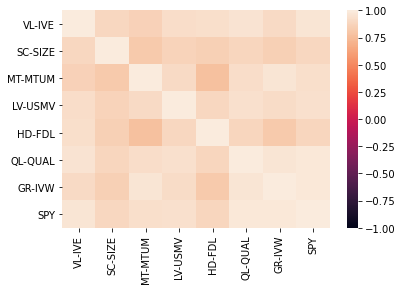

In [25]:
# return correlation, beta: positive correlation. High Dividend EFTs seems to correlated more 
correlation = funds_return.corr()
sns.heatmap(correlation, vmin =-1, vmax=1)

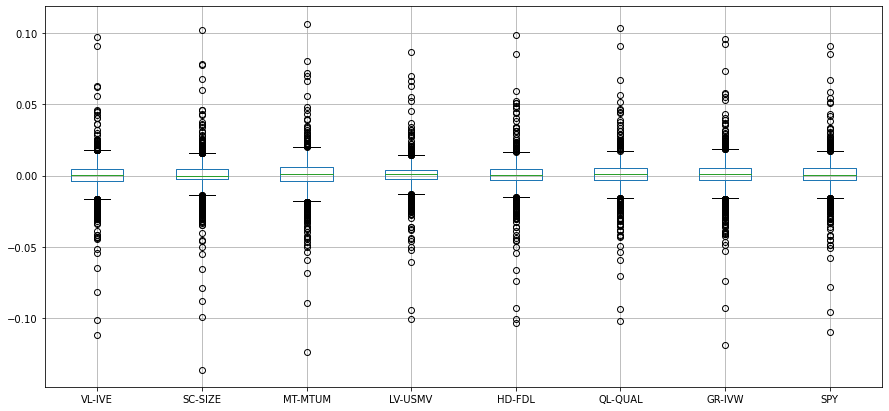

In [26]:
#distribution of returns
boxplot_return_dist = funds_return.boxplot(figsize = (15,7), grid = True)

Looking at fund's return volatility in the past 7 years, all active funds have similar vol as S&P except Low Vol fund which try to capture beta by low-volatile stick in nature. 

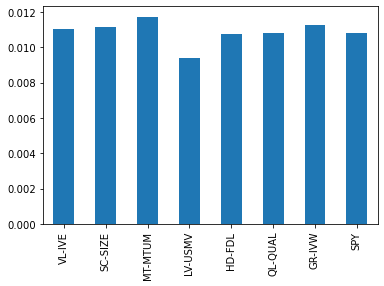

In [27]:
#long-term volatilityof return
funds_return_std = funds_return.std()
funds_return_std.plot(kind="bar")

In term of tradeoff between risk and return, Momentum(Sharpe ratio 1.26), Growth (1.28), Quality (1.04) and Low Vol (0.68) Funds offer better risk-adjusted return compared to S&P index(0.65). 

Active funds could outperform S&P by 4% annually. Annualized return from investing in S&P in the past 7 years is 10.29% (annualized return since inception). The best performer among active funds is Momentum (MT-MTUM) which generate annualized return at 14.60%. Follow by Growth (GR-IVW, 14.37%), Quality (QL-QUAL, 10.91%). Even Value funds underperform S&P but annualized return are still positive. Majority of High Dividend funds generate loss.

However, rank of performance change in recent shorter horizon. Outperformance of Momentum fund is pretty robust, except in the past 3 months that Momentum Fund (17.72%) underperform S&P (18.20%). Growth Fund (21.41%) and Small Cap Fund (20.72%) are the best performers in the past 3 months as propect of economic growth improved.

Growth fund is also performed slightly better than market index during tough time. Maximum Drawdown of Momentum fund is -34.08%, slightly than -34.10% of S&P index. However, MDD is shallower for HD-HYG (-28.05%). In contrast, MDD are deeper in HD-FDL (-41.40%) and HD-SDIV (-69.08%).

In [28]:
#backtesting
backtest = funds_df.calc_stats()
backtest.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18
End                  2020-08-14  2020-08-14  2020-08-14  2020-08-14  2020-08-14  2020-08-14  2020-08-14  2020-08-14
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         45.32%      79.51%      163.26%     89.69%      27.22%      107.36%     158.56%     99.47%
Daily Sharpe         0.39        0.56        0.83        0.68        0.29        0.69        0.84        0.65
Daily Sortino        0.58        0.81        1.26        1.02        0.42        1.04        1.28        0.98
CAGR                 5.42%       8.62%       14.66%      9.47%       3.46%       10.86%      14.37%

Examine risk and return characteristics of passive and active funds in different economic/market scenarios in the past to get better idea how Momentum, Quality and Growth funds outperform market index. Given limitation of fund’s data which allow us to go back just 7 years, we set scenarios into 3 scenarios. (1) Taper Tantrum which represent the period of high market volatility in 2013  as investors feared that Fed will withdraw large amount of support in bond market and could increase funding rate. (2) Hike cycle in 2016-18  which represent period of good economic growth that Fed feel confident to increase policy rate. (3) Recent market turmoil during COVID pandemic which cause VIX index to spike in Mar. 

During Taper Tantrum period in 2013, Momentum (25.66% since incep ann) and Quality (30.10%) funds outperformed S&P (21.78%). Value fund (15.79-15.95%) turned out underperformed market index and were more volatile. Similar conclusion seen in pandemic scenario. Momentum (25.66%) also outperformed S&P (21.78%) during hiking cycle together with Low Vol (8.29%) and Growth (9.86%).

During market turmoil, Growth Fund has smallest MDD (-25.73%) and slightly lower than S&P (-28.74%).  

In [29]:
#economic cycle:cutting cycle(none),Taper Tantrum(2013), goldilock/hike cycle(2016-18), pandemic(Mar-May2020)
#slice return datafram into scenarios
funds_return_taper_tantrum = funds_return.loc['20130718':'20131231']
funds_return_hike_cycle = funds_return.loc['20160102':'20181231']
funds_return_pandemic = funds_return.loc['20200302':'20200330']
#slice price dataframe into scenarios
funds_df_taper_tantrum = funds_df.loc['20130718':'20131231']
funds_df_hike_cycle = funds_df.loc['20160102':'20181231']
funds_df_pandemic = funds_df.loc['20200302':'20200330']

In [30]:
#backtest funds during Taper Tantrum
backtest_taper_tantrum = funds_df_taper_tantrum.calc_stats()
backtest_taper_tantrum.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18
End                  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         6.89%       8.45%       10.94%      4.87%       2.48%       12.70%      11.54%      9.37%
Daily Sharpe         1.49        1.81        2.34        1.19        0.63        2.84        2.48        2.04
Daily Sortino        2.81        2.82        4.35        2.42        1.11        5.04        4.66        3.81
CAGR                 15.79%      19.53%      25.66%      11.04%      5.54%       30.10%      27.17% 

In [31]:
#backtest funds during hiking cycle
backtest_hike_cycle = funds_df_hike_cycle.calc_stats()
backtest_hike_cycle.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04
End                  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         15.61%      21.25%      39.58%      26.88%      15.87%      20.65%      32.46%      24.33%
Daily Sharpe         0.45        0.60        0.80        0.83        0.50        0.56        0.73        0.62
Daily Sortino        0.68        0.91        1.22        1.26        0.75        0.84        1.10        0.94
CAGR                 4.97%       6.66%       11.80%      8.29%       5.05%       6.48%       9.86% 

In [32]:
#backtest funds during pandemic
backtest_pandemic = funds_df_pandemic.calc_stats()
backtest_pandemic.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02
End                  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -18.21%     -20.07%     -13.34%     -14.37%     -21.83%     -14.13%     -12.98%     -15.35%
Daily Sharpe         -2.16       -2.24       -1.38       -1.86       -2.76       -1.62       -1.40       -1.81
Daily Sortino        -3.70       -3.60       -2.39       -3.20       -4.63       -2.90       -2.42       -3.09
CAGR                 -92.73%     -94.62%     -84.54%     -86.78%     -95.98%     -86.30%     -83

Interestingly, every funds correalted more with S&P during crisis time when volatiliry in the market spike. This could mean benefit of diversify among passive/active could become lower durinf crisis time.

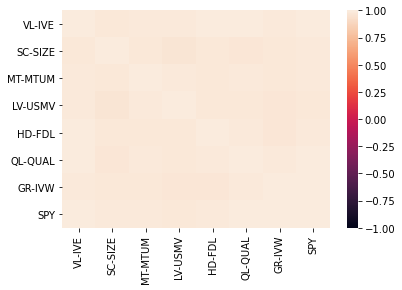

In [33]:
#correlation in different periods/cycle
correlation_pandemic = funds_return_pandemic.corr()
sns.heatmap(correlation_pandemic, vmin =-1, vmax=1)

## Visualization of findings from historical return analysis

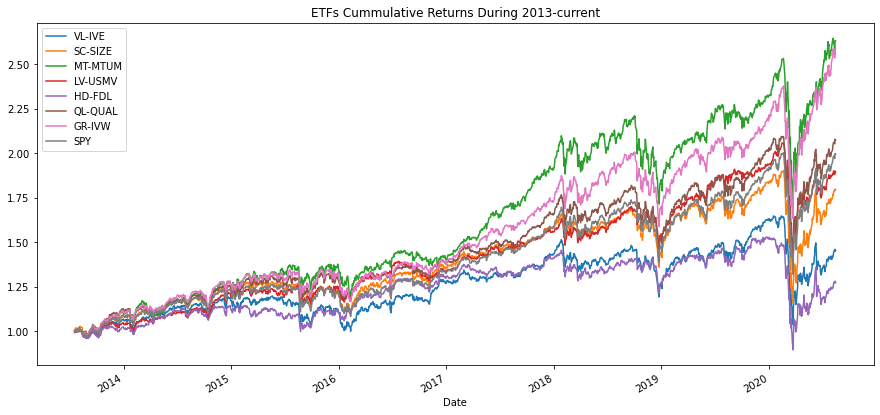

In [34]:
# Cummulative return: Growth, Momentum and Qualirty ETFs outperform SPY during 2013-current.
funds_return_cum = (1+funds_return).cumprod()
funds_return_cum.plot(figsize = (15,7), title = "ETFs Cummulative Returns During 2013-current")

### In term of tradeoff between risk and return, Momentum(Sharpe ratio 1.26), Growth (1.28), Quality (1.04) and Low Vol (0.68) Funds offer better risk-adjusted return compared to S&P index(0.65). 

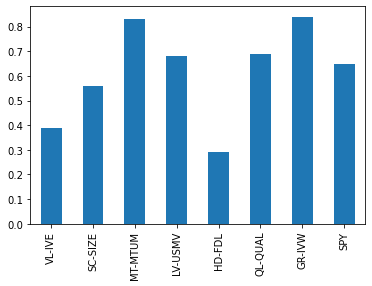

In [35]:
# Sharpe ratio: Risk/return tradeoff are less attractive in High Dividend funds. Most attractive in Momentum, Quality and Growth funds.
funds_return_sharpe = round((funds_return.mean()*252)/(funds_return.std() * np.sqrt(252)),2)
funds_return_sharpe.plot(kind="bar")

### Outperformance of Momentum fund is pretty robust under different scenarios, except in the past 3 months that Momentum Fund underperform S&P. Growth Fund and Small Cap Fund are the best performers in the past 3 months as propect of economic growth improved.

In [36]:
funds_df_3m = funds_df.loc['20200514':'20200814']
total_return_all = round(ffn.core.calc_total_return(funds_df)*100,2)
total_return_3m = round(ffn.core.calc_total_return(funds_df_3m)*100,2)
total_return_taper_tantrum = round(ffn.core.calc_total_return(funds_df_taper_tantrum)*100,2)
total_return_pandemic = round(ffn.core.calc_total_return(funds_df_pandemic)*100,2)
total_return_hike_cycle = round(ffn.core.calc_total_return(funds_df_hike_cycle)*100,2)
total_return_scenarios = pd.concat([total_return_all, total_return_3m, total_return_taper_tantrum,total_return_pandemic,total_return_hike_cycle], axis = 1,keys=['Total','Last 3M','Taper Tantum','Pandemic','Hike Cycle'])
total_return_scenarios

,Total,Last 3M,Taper Tantum,Pandemic,Hike Cycle
VL-IVE,45.32,14.05,6.89,-18.21,15.61
SC-SIZE,79.51,20.72,8.45,-20.07,21.25
MT-MTUM,163.26,17.72,10.94,-13.34,39.58
LV-USMV,89.69,10.88,4.87,-14.37,26.88
HD-FDL,27.22,15.01,2.48,-21.83,15.87
QL-QUAL,107.36,15.81,12.70,-14.13,20.65
GR-IVW,158.56,21.41,11.54,-12.98,32.46
SPY,99.47,18.20,9.37,-15.35,24.33


### Less downside risk is seen in Growth Fund during market turmoil. However, every funds correalted more with S&P during crisis time when volatility in the market spike. This could mean benefit of diversify among passive/active could become lower durinf crisis time.

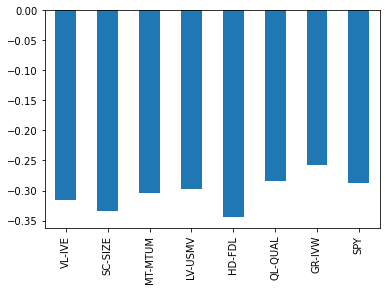

In [37]:
ffn.core.calc_max_drawdown(funds_df_pandemic).plot(kind="bar")

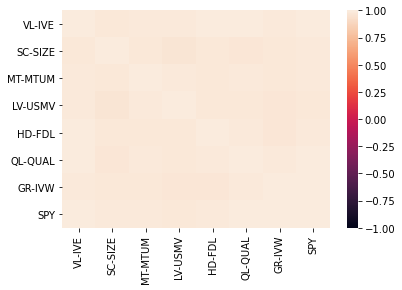

In [38]:
sns.heatmap(correlation_pandemic, vmin =-1, vmax=1)

# 4. Simulated Return and Portfolio Optimization

## Monte Carlo Simulations for SPY and Factors EFT

In [39]:
# Calculate the daily roi for the stocks
funds_return

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2013-07-19,0.003502,0.000000,0.004435,0.002363,0.002339,-0.007777,-0.000339,0.001777
2013-07-22,0.002119,0.018100,0.001288,0.000295,0.000000,0.004823,0.001808,0.001951
2013-07-23,0.000249,0.000000,-0.001654,-0.001178,0.003733,-0.001600,-0.003609,-0.002124
2013-07-24,-0.006466,0.000000,-0.003497,-0.006490,-0.006973,-0.001402,-0.001019,-0.003666
2013-07-25,0.002128,0.000000,0.007573,0.003860,0.004213,0.005216,0.002946,0.002433
...,...,...,...,...,...,...,...,...
2020-08-10,0.009642,0.008387,-0.007885,-0.001088,0.010725,0.002421,-0.001451,0.002989
2020-08-11,-0.002581,-0.002106,-0.020153,-0.009182,-0.001829,-0.005023,-0.011842,-0.008255
2020-08-12,0.007332,0.006647,0.027086,0.010209,0.004032,0.012524,0.019067,0.013942


In [40]:
# Display sample data
funds_return.sample()

,VL-IVE,SC-SIZE,MT-MTUM,LV-USMV,HD-FDL,QL-QUAL,GR-IVW,SPY
Date,,,,,,,,
2019-04-05,0.00548,0.006805,0.004194,0.004409,0.004613,0.00512,0.003894,0.00484


In [41]:
# Compute daily roi volatility
funds_return_vol= funds_return.std()
funds_return_vol

VL-IVE     0.011016
SC-SIZE    0.011139
MT-MTUM    0.011736
LV-USMV    0.009390
HD-FDL     0.010753
QL-QUAL    0.010828
GR-IVW     0.011264
SPY        0.010820
dtype: float64

In [42]:
funds_return_vol_fdl = funds_return["HD-FDL"].std()
funds_return_vol_fdl

0.010752585906117065

In [43]:
funds_return_vol_ive = funds_return["VL-IVE"].std()
funds_return_vol_ive

0.01101552353658306

In [44]:
funds_return_vol_ivw = funds_return["GR-IVW"].std()
funds_return_vol_ivw

0.011263552344499628

In [45]:
funds_return_vol_mtum = funds_return["MT-MTUM"].std()
funds_return_vol_mtum

0.011735570660030286

In [46]:
funds_return_vol_qual = funds_return["QL-QUAL"].std()
funds_return_vol_qual

0.010828465936228196

In [47]:
funds_return_vol_size = funds_return["SC-SIZE"].std()
funds_return_vol_size

0.011139330296638751

In [48]:
funds_return_vol_spy = funds_return["SPY"].std()
funds_return_vol_spy

0.010819910482372973

In [49]:
funds_return_vol_usmv = funds_return["LV-USMV"].std()
funds_return_vol_usmv

0.009390342930315671

In [50]:
# Compute daily roi average
funds_daily_return_fdl = funds_return["HD-FDL"].mean()
funds_daily_return_fdl

0.0001933335274732707

In [51]:
funds_daily_return_ive = funds_return["VL-IVE"].mean()
funds_daily_return_ive

0.0002707799291291307

In [52]:
funds_daily_return_ivw = funds_return["GR-IVW"].mean()
funds_daily_return_ivw

0.0005969328913784723

In [53]:
funds_daily_return_mtum = funds_return["MT-MTUM"].mean()
funds_daily_return_mtum

0.0006125049693035996

In [54]:
funds_daily_return_qual = funds_return["QL-QUAL"].mean()
funds_daily_return_qual

0.0004681198962246045

In [55]:
funds_daily_return_size = funds_return["SC-SIZE"].mean()
funds_daily_return_size

0.0003910488673849596

In [56]:
funds_daily_return_spy = funds_return["SPY"].mean()
funds_daily_return_spy

0.00044640821340453203

In [57]:
funds_daily_return_usmv = funds_return["LV-USMV"].std()
funds_daily_return_usmv

0.009390342930315671

In [58]:
# Save the last day's closing price
last_day_fdl = funds_return["HD-FDL"][-1]
last_day_fdl

0.001472787767013095

In [59]:
last_day_ive = funds_return["VL-IVE"][-1]
last_day_ive

0.002588911450366549

In [60]:
last_day_ivw = funds_return["GR-IVW"][-1]
last_day_ivw

-0.0009602008789787453

In [61]:
last_day_mtum = funds_return["MT-MTUM"][-1]
last_day_mtum

-0.0007716092328519109

In [62]:
last_day_qual = funds_return["QL-QUAL"][-1]
last_day_qual

-0.00048061371893304283

In [63]:
last_day_size = funds_return["SC-SIZE"][-1]
last_day_size

0.0009461347276280563

In [64]:
last_day_spy = funds_return["SPY"][-1]
last_day_spy

2.9717560858788516e-05

In [65]:
last_day_usmv = funds_return["LV-USMV"][-1]
last_day_usmv

0.00015579652189900983

In [66]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
simulated_price_df= pd.DataFrame()
portfolio_cumulative_returns= pd.DataFrame()

In [67]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
simulated_price_df= pd.DataFrame()
portfolio_cumulative_returns= pd.DataFrame()

In [68]:
# Run the Monte Carlo Simulation
for simulations in range(number_simulations):
    simulated_fdl_prices=[last_day_fdl]
    simulated_ive_prices=[last_day_ive]
    simulated_ivw_prices=[last_day_ivw]
    simulated_mtum_prices=[last_day_mtum]
    simulated_qual_prices=[last_day_qual]
    simulated_size_prices=[last_day_size]    
    simulated_spy_prices=[last_day_spy]
    simulated_usmv_prices=[last_day_usmv]
    
    for days in range(number_records):
        simulated_fdl_price=simulated_fdl_prices[-1]*(1+np.random.normal(abs(funds_daily_return_fdl),abs(funds_return_vol_fdl)))
        simulated_ive_price =simulated_ive_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ive),abs(funds_return_vol_ive)))
        simulated_ivw_price =simulated_ivw_prices[-1]*(1+np.random.normal(abs(funds_daily_return_ivw),abs(funds_return_vol_ivw)))
        simulated_mtum_price=simulated_mtum_prices[-1]*(1+np.random.normal(abs(funds_daily_return_mtum),abs(funds_return_vol_mtum)))
        simulated_qual_price=simulated_qual_prices[-1]*(1+np.random.normal(abs(funds_daily_return_qual),abs(funds_return_vol_qual)))
        simulated_size_price=simulated_size_prices[-1]*(1+np.random.normal(abs(funds_daily_return_size),abs(funds_return_vol_size)))
        simulated_spy_price =simulated_spy_prices[-1]*(1+np.random.normal(abs(funds_daily_return_spy),abs(funds_return_vol_spy)))
        simulated_usmv_price=simulated_usmv_prices[-1]*(1+np.random.normal(abs(funds_daily_return_usmv),abs(funds_return_vol_usmv)))  
        
        
        simulated_fdl_prices.append(simulated_fdl_price)
        simulated_ive_prices.append(simulated_ive_price)
        simulated_ivw_prices.append(simulated_ivw_price)
        simulated_mtum_prices.append(simulated_mtum_price)
        simulated_qual_prices.append(simulated_qual_price)
        simulated_size_prices.append(simulated_size_price)   
        simulated_spy_prices.append(simulated_spy_price)
        simulated_usmv_prices.append(simulated_usmv_price)
        
     
        
    simulated_price_df["HD-FDL"]=simulated_fdl_prices
    simulated_price_df["VL-IVE"]=simulated_ive_prices
    simulated_price_df["GR-IVW"]=simulated_ivw_prices
    simulated_price_df["MT-MTUM"]=simulated_mtum_prices
    simulated_price_df["QL-QUAL"]=simulated_qual_prices
    simulated_price_df["SC-SIZE"]=simulated_size_prices
    simulated_price_df["SPY"]= simulated_spy_prices
    simulated_price_df["LV-USMV"]=simulated_usmv_prices
    
    simulated_daily_returns=simulated_price_df.pct_change()
    weights=[0.05,0.05,0.2,0.2,0.15,0.5,0.15,0.15,]
    portfolio_daily_returns=simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[simulations]= (1+portfolio_daily_returns.fillna(0)).cumprod()
   

In [69]:
len(simulated_ivw_prices)

7561

In [70]:
abs(funds_return_vol_spy)

0.010819910482372973

In [71]:
# Check that the simulation ran successfully
simulated_price_df.head()

,HD-FDL,VL-IVE,GR-IVW,MT-MTUM,QL-QUAL,SC-SIZE,SPY,LV-USMV
0,0.001473,0.002589,-0.000960,-0.000772,-0.000481,0.000946,0.000030,0.000156
1,0.001474,0.002601,-0.000971,-0.000783,-0.000491,0.000941,0.000029,0.000157
2,0.001472,0.002621,-0.000979,-0.000769,-0.000490,0.000950,0.000029,0.000159
3,0.001501,0.002624,-0.000972,-0.000776,-0.000500,0.000953,0.000030,0.000160
4,0.001494,0.002602,-0.000955,-0.000762,-0.000496,0.000943,0.000030,0.000163


In [72]:
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,2.071755e+06,2.167020e+06,5.781137e+06,1.927511e+06,1.166558e+06,1.208245e+06,5.030643e+06,6.439660e+06,1.752737e+06,4.455409e+06,...,1.464341e+06,3.260824e+06,5.013975e+06,2.852384e+06,748381.358259,2.343838e+06,5.336469e+06,3.071127e+06,5.027605e+06,5.611248e+06
7557,2.086352e+06,2.173520e+06,5.769140e+06,1.921052e+06,1.161531e+06,1.216163e+06,5.036504e+06,6.480531e+06,1.744886e+06,4.451726e+06,...,1.454467e+06,3.290096e+06,5.011037e+06,2.818029e+06,744185.119788,2.368312e+06,5.324907e+06,3.092712e+06,5.059692e+06,5.593262e+06
7558,2.071209e+06,2.210864e+06,5.709464e+06,1.925462e+06,1.168658e+06,1.229418e+06,5.100031e+06,6.490108e+06,1.753893e+06,4.425798e+06,...,1.452733e+06,3.330223e+06,4.986304e+06,2.830964e+06,741585.112512,2.367832e+06,5.319719e+06,3.083450e+06,5.080534e+06,5.560701e+06
7559,2.056499e+06,2.219776e+06,5.759053e+06,1.933488e+06,1.168839e+06,1.223500e+06,5.091841e+06,6.512654e+06,1.761476e+06,4.454596e+06,...,1.480373e+06,3.342994e+06,4.966061e+06,2.860345e+06,748834.061591,2.370136e+06,5.369947e+06,3.111853e+06,5.111715e+06,5.526466e+06
7560,2.066627e+06,2.220872e+06,5.731057e+06,1.933819e+06,1.176692e+06,1.213376e+06,5.042858e+06,6.538185e+06,1.775366e+06,4.468792e+06,...,1.482559e+06,3.350804e+06,4.976340e+06,2.847820e+06,751592.730251,2.383323e+06,5.364951e+06,3.104433e+06,5.106886e+06,5.468274e+06


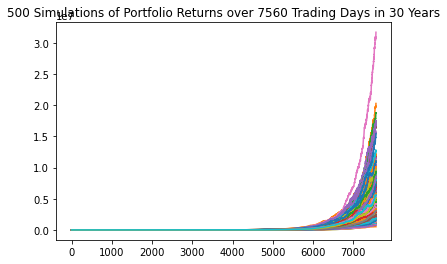

In [73]:
# Visualize the Simulation
plot_title=f"{number_simulations} Simulations of Portfolio Returns over {number_records} Trading Days in 30 Years"
portfolio_cumulative_returns.plot(legend=None,title=plot_title)

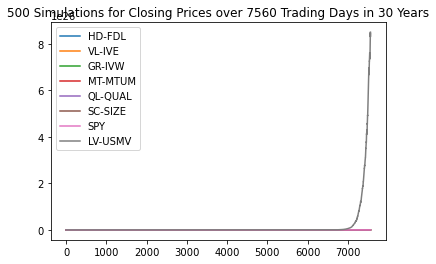

In [74]:
plot_title2=f"{number_simulations} Simulations for Closing Prices over {number_records} Trading Days in 30 Years"
simulated_price_df.plot(title=plot_title2)

In [75]:
# last row for the cumulative returns
simulated_price_df[-1:]

,HD-FDL,VL-IVE,GR-IVW,MT-MTUM,QL-QUAL,SC-SIZE,SPY,LV-USMV
7560,0.007946,0.013106,-0.043493,-0.044379,-0.004341,0.052707,0.00024,8.490351e+26


In [76]:
cumulative_ret = portfolio_cumulative_returns.iloc[-1,:]
cumulative_ret

0      2.066627e+06
1      2.220872e+06
2      5.731057e+06
3      1.933819e+06
4      1.176692e+06
           ...     
495    2.383323e+06
496    5.364951e+06
497    3.104433e+06
498    5.106886e+06
499    5.468274e+06
Name: 7560, Length: 500, dtype: float64

In [77]:
# Display the 90% confidence interval for the ending returns
confidence_interval= cumulative_ret.quantile(q=[0.05,0.95])
confidence_interval

0.05    1.287321e+06
0.95    9.079235e+06
Name: 7560, dtype: float64

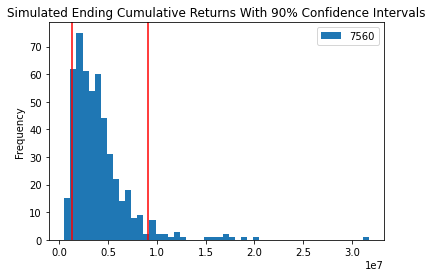

In [78]:
# Visualize the distribution of the ending returns
cumulative_ret.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval.iloc[0],color='r')
plt.axvline(confidence_interval.iloc[1],color='r')

## Optimization

## Risk/Return Analysis of the Optimal Portfolio

# 5. Data Insights/Reporting

## Tab 1: Passive vs Active Portfolios Performance

## Tab 2: Suggested Optimal Allocation